In [1]:
# Import Applicable Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

import os

import statistics

In [2]:
# User Input Section
# Welcome to StarData! This code requires three inputs to run properly.

# 1. Type the name of the excel file of interest into the quotation marks for file_path.
file_path = "ExampleRunFile.xlsx"

# 2. Type the name of the sheet on the excel file of interest you wish to evaluate. Either 'Mag Select' or 'Name Select.'
sheet_name = 'Mag Select'

# 3. Give your data export a unique name.
runName = 'ManualData'

# 4. Specify which series the data originates from by letter (H, R, or S)
series = 'H'

# Run the code.

In [22]:
# Section 1: Import the star charts
# Code to create file naming convention
df_naming = pd.read_excel(file_path, 'RSCs', header = None)
df_naming = df_naming.head(4)

horizon = df_naming.loc[0,0]
horizon = horizon.lstrip('horizon is ')

altitude = df_naming.loc[1,0]
altitude = altitude.lstrip('alt window is ')

binSize = df_naming.loc[2,0]
binSize = binSize.lstrip('bsize = ')

gapSize = df_naming.loc[3,0]
gapSize = gapSize.lstrip('gsize = ')

typeSelect = sheet_name.rstrip(' Select')

File_Name = f"{runName}_{series}series_{typeSelect}Sel_Horizon{horizon}altWindow{altitude}_bSize{binSize}_gSize{gapSize}"

# Create the file
path = f'./{File_Name}'
os.makedirs(path, exist_ok=True)

# Code organizing Excel file
try:
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name)
    df = df.iloc[4:] # Remove first 4 rows
    df.reset_index(drop=True, inplace=True) # Reset the index of the rows so it starts at 0 again
    
    new_columns = {'horizon is (?, ?)': 'Hour','Unnamed: 1': '-3','Unnamed: 2': '-2','Unnamed: 3': '-1','Unnamed: 4': '0',
                   'Unnamed: 5': '1','Unnamed: 6': '2','Unnamed: 7': '3'}
    df.rename(columns=new_columns, inplace=True) # Rename the columns
    
    # Display the entire chart
    #pd.set_option('display.max_rows', None) 
    #print(df)

# Error messages
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

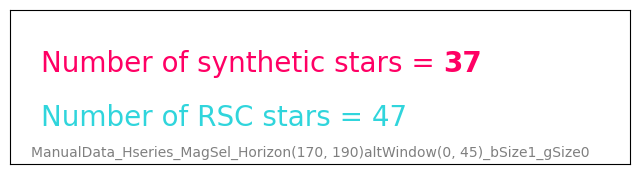

In [4]:
# Section 2: Convert data to general format
# 2a) Looks through the star charts, outputs a list of the stars in it and counts how many stars are represented

# Function to return unique values from a DataFrame excluding specified values
# For our data, unique values are synonomous with stars
def get_unique_values(dataframe, exclude_values=None):
    unique_values = set()
    for column in dataframe.columns:
        if exclude_values:
            unique_values.update([value for value in dataframe[column].unique() 
                                  if pd.notna(value) and value not in exclude_values])
        else:
            unique_values.update(dataframe[column].unique())
    return unique_values

# Specify uniqe values to be excluded, ie non-star names like star clock position columns -3 to 3,
# hour markings 0 to 12, table names
exclude_values = set(range(-3, 13)) 
exclude_values.update(['Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 
                        'Table 7', 'Table 8', 'Table 9', 'Table 10', 'Table 11', 'Table 12', 
                        'Table 13', 'Table 14', 'Table 15', 'Table 16', 'Table 17', 'Table 18', 
                        'Table 19', 'Table 20', 'Table 21', 'Table 22', 'Table 23', 'Table 24','?'])

# Get unique values from the DataFrame excluding specified values, then print the values (stars)
uniqueStars = get_unique_values(df, exclude_values)
starCounter = len(uniqueStars)

# Beginning of new dataframe, where each row is a unique star
gen_df = pd.DataFrame({'Stars': list(uniqueStars)})

# 2a) i. Star Count Figure
fig = plt.figure()
fig.set_size_inches(8, 2)  # Set the size of the figure (width, height)
ax = fig.add_subplot(xticks=[], yticks=[])

# The first word, created with text().
text = ax.text(.05, .6, "Number of synthetic stars = ", color=(255/255, 0/255, 100/255),fontsize=20)
# Subsequent words, positioned with annotate(), relative to the preceding one.
text = ax.annotate(
    f"{starCounter}", xycoords=text, xy=(1, 0), verticalalignment="bottom",
    color=(255/255, 0/255, 100/255), weight="bold",fontsize=20)  # custom properties

text = ax.text(.05, .25, "Number of RSC stars = 47", color=(48/255, 213/255, 220/255),fontsize=20)

plt.suptitle(f'{File_Name}', alpha=0.5, x=0.5, y=0.2,fontsize=10)

# Save the figure into desired folder
plt.savefig(f"{path}/starCounter.png")

plt.show()

In [23]:
# 2b) Finds the index (row) and column of every star. From the index, also finds the table and hour for each star.

# Initialize an empty list to store dataframes
dfs = []

# Iterate through each value in gen_df
for col_gen, row_gen in gen_df.items():
    for idx_gen, val_gen in row_gen.items():
        # Search for the value in df
        for idx_df, row_df in df.iterrows():
            for col_df, val_df in row_df.items():
                # Check if the value matches
                if val_df == val_gen:
                    # Calculate table number based on index. IMPORTANT
                    table_number = (idx_df + 15) // 15
                    # Calculate hour based on index and table number. IMPORTANT
                    Hour = idx_df - 15*(table_number - 1) - 1
                    # Create a temporary dataframe with the match
                    match_df = pd.DataFrame({'Star': [val_df],
                                             'Index': [idx_df],
                                             'Position': [col_df],
                                             'Table #': [table_number],
                                             'Hour': [Hour]})
                    # Append the temporary dataframe to the list
                    dfs.append(match_df)

# Concatenate all temporary DataFrames into one DataFrame
int_df = pd.concat(dfs, ignore_index=True)

#print(int_df)

In [24]:
# 2c) Converts int_df into the ideal table (id_df)

# Create id_df with appropriate column names
columns = []
for i in range(1, 25):
    columns.extend([f'H{i}', f'P{i}'])

id_df = pd.DataFrame(index=gen_df['Stars'], columns=columns)  # Set index to 'Stars'

# Iterate through int_df and fill id_df accordingly
for index, row in int_df.iterrows():
    star_name = row['Star']
    table_num = row['Table #']
    position = row['Position']
    hour = row['Hour']
    
    if star_name in id_df.index:
        id_df.at[star_name, f'P{table_num}'] = position
        id_df.at[star_name, f'H{table_num}'] = hour

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#print(id_df)

In [25]:
# Section 3: Star Stability Chart
# 3a) Convert Hour to Star Appearance from table

# Create columns numbered from 1 to 13
columns = range(1, 14)

# Create an empty DataFrame with the required index and columns
ss_df = pd.DataFrame(index=id_df.index, columns=columns)

# Function to convert hour to star appearance
# Such that an appearance in hour 12 is a stars first appearance, hour 11 the second, and so on.
# Anything that's not a number 0-12 (there should NOT be any) ends up in an error column that is subsequently removed.
def determine_column(value):
    if value == 12:
        return 1
    elif value == 11:
        return 2
    elif value == 10:
        return 3
    elif value == 9:
        return 4
    elif value == 8:
        return 5
    elif value == 7:
        return 6
    elif value == 6:
        return 7
    elif value == 5:
        return 8
    elif value == 4:
        return 9
    elif value == 3:
        return 10
    elif value == 2:
        return 11
    elif value == 1:
        return 12
    elif value == 0:
        return 13
    else:
        return 'error'

# Loop through id_df and fill ss_df accordingly
for index, row in id_df.iterrows():
    for col_label in id_df.columns:
        if col_label.startswith('H'):
            value = row[col_label]
            col_num = determine_column(value)
            # Construct the label of the corresponding position 'P' column from the ideal dataframe id_df
            p_col_label = 'P' + col_label[1:]
            if p_col_label in id_df.columns:  # Check if the 'P' column exists
                p_value = row[p_col_label]  # Get the value from the corresponding 'P' column
                ss_df.at[index, col_num] = p_value  # Assign it to the corresponding column in ss_df
            else:
                ss_df.at[index, col_num] = None  # If the 'P' column doesn't exist, assign None to the corresponding column in ss_df

# Convert the table to float values. I FORGET WHY I DID THIS???
ss_df = ss_df.astype(float) 

#print(ss_df.drop(columns=['error']))

In [8]:
# Section 3b) Sort ss_df from least to most appearances
# This is mostly for the benefit of the average position (standard deviation) chart so it can be sorted by frequency.

sorted_ss_df = ss_df.count(axis=1).sort_values(ascending=False).index
sorted_ss_df = ss_df.loc[sorted_ss_df]

#print(sorted_ss_df)

In [9]:
# 3c) Drop low frequency stars. THIS IS IMPORTANT CODE.

#copy the dataframe ss_df
ss_dfdropped = ss_df.copy(deep=True)

# DEFAULT 11 APPEARANCES TO GET ON THE STAR STABILITY CHART. EDIT AS YOU PLEASE.
# This will automatically update the axis label on the chart itself.
threshold = 11

ss_dfdropped = ss_dfdropped.dropna(thresh=threshold) # Drop rows with less than 'threshold' non-nan values
ss_dfdropped = ss_dfdropped.drop(columns='error') # Drop the error column

#print(ss_dfdropped)

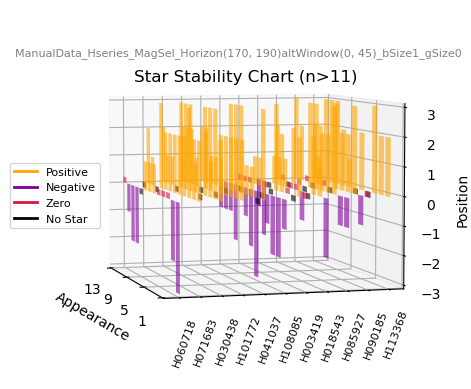

In [10]:
# 3d) Star Stability Chart

ss_dfdropped = ss_dfdropped.replace(0, 0.2) # Replace 0's with 0.2 so runs of 0 are represented on the chart
ss_dfdropped.fillna(-0.2, inplace=True) # Replace NaNs with -0.2 so they are represented on the chart

# Custom colors for positive and negative bars
color_start = [255/255, 165/255, 0/255]
color_end = [128/255, 0/255, 153/255]
color_zero = [220/255, 20/255, 60/255]
color_nan = [0/255, 0/255, 0/255]

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop through each index (y values)
for i, index in enumerate(ss_dfdropped.index):
    # Extract x values (columns of ss_df, star appearance) and y values (index of ss_df, stars)
    x = np.arange(1, 14)
    y = np.repeat(i + 1, 13)  # Adjusted index for bar graph

    # Extract z values (position)
    z = ss_dfdropped.loc[index].values
    
    # Define colors based on positive or negative values
    colors = [color_nan if val == -0.2 else (color_zero if val == 0.2 else (color_start if val > 0 else color_end)) for val in z]
    
    # Plot 2D bar graph
    bars = ax.bar(x, z, zs=y, zdir='y', color=colors, alpha=0.6)   

# Set labels and title
ax.set_xlabel('Appearance')
ax.set_zlabel('Position')
ax.set_title(f'Star Stability Chart (n>{threshold})', x=0.5, y=0.85)
plt.suptitle(f'{File_Name}', alpha=0.5, x=0.5, y=0.8, fontsize=8)
plt.yticks(rotation=70, fontsize=8)
plt.xticks([1, 5, 9, 13])

# Set tick labels on the y-axis to the DataFrame index values
ax.set_yticks(np.arange(1, len(ss_dfdropped.index) + 1))
ax.set_yticklabels(ss_dfdropped.index)

# Set range of x-axis
ax.set_xlim(1, 13)

# Set viewing angle
ax.view_init(elev=5, azim=164) # Adjust the elevation (vertical) and azimuth (horizontal) angles

legend_elements = [Line2D([0], [0], color=color_start, lw=2, label='Positive'),
                  Line2D([0], [0], color=color_end, lw=2, label='Negative'),
                  Line2D([0], [0], color=color_zero, lw=2, label='Zero'),
                  Line2D([0], [0], color=color_nan, lw=2, label='No Star')]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.12, 0.6),fontsize = 8)

# Save the figure into desired folder
plt.savefig(f"{path}/star_stability.png")

# Show plot
plt.show()

In [11]:
# Section 4: Frequency Table

# Copy the general dataframe to make small changes
ft_df = id_df.copy(deep=True)
#print(ft_df)

# Drop position columns
columns_to_drop = [col for col in ft_df.columns if col.startswith('P')]
ft_df = ft_df.drop(columns=columns_to_drop)

# Organize the columns by their first appearance
ft_df = ft_df.sort_values(by='H24')
ft_df = ft_df.sort_values(by='H23')
ft_df = ft_df.sort_values(by='H22')
ft_df = ft_df.sort_values(by='H21')
ft_df = ft_df.sort_values(by='H20')
ft_df = ft_df.sort_values(by='H19')
ft_df = ft_df.sort_values(by='H18')
ft_df = ft_df.sort_values(by='H17')
ft_df = ft_df.sort_values(by='H16')
ft_df = ft_df.sort_values(by='H15')
ft_df = ft_df.sort_values(by='H14')
ft_df = ft_df.sort_values(by='H13')
ft_df = ft_df.sort_values(by='H12')
ft_df = ft_df.sort_values(by='H11')
ft_df = ft_df.sort_values(by='H10')
ft_df = ft_df.sort_values(by='H9')
ft_df = ft_df.sort_values(by='H8')
ft_df = ft_df.sort_values(by='H7')
ft_df = ft_df.sort_values(by='H6')
ft_df = ft_df.sort_values(by='H5')
ft_df = ft_df.sort_values(by='H4')
ft_df = ft_df.sort_values(by='H3')
ft_df = ft_df.sort_values(by='H2')
ft_df = ft_df.sort_values(by='H1')

# Rename columns by removing 'H'
ft_df.columns = [col.replace('H', '') for col in ft_df.columns]

# Replace NaN's with empty strings
ft_df = ft_df.fillna('')

def set_transparency(val):
    try:
        # Attempt to convert the value to a float
        numeric_val = float(val)
        # Scale the value to be between 0 and 1
        alpha = max(0, min(1, (numeric_val + 1) / 13))
        # Define the gradient color
        start_color = "#FFFFFF"  # White
        end_color = "#FF0064"    # Pink
        # Interpolate between start and end colors based on alpha
        def hex_to_rgb(hex_color):
            return tuple(int(hex_color[i:i + 2], 16) for i in (1, 3, 5))
        
        def rgb_to_hex(rgb_color):
            return '#{:02x}{:02x}{:02x}'.format(*rgb_color)
        
        start_rgb = hex_to_rgb(start_color)
        end_rgb = hex_to_rgb(end_color)
        
        color_rgb = [int((1 - alpha) * start_rgb[i] + alpha * end_rgb[i]) for i in range(3)]
        
        color_hex = rgb_to_hex(color_rgb)
        
        return 'background-color: %s' % color_hex
    except ValueError:
        # If the value cannot be converted to a float, return empty string
        return ''

ft_df.style.\
    applymap(set_transparency).\
    to_excel(f'{path}/freqTable_{File_Name}.xlsx', engine='openpyxl')

ft_df.style.applymap(set_transparency)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Stars,,,,,,,,,,,,,,,,,,,,,,,,
H015474,0,,,,,,,,,,,,,,,11,,8,7,6,,,,
H018543,1,0,,,,,,,,,,,,,,12,11,10,8,7,6,5,4,3
H020042,2,,,,,,,,,,,,,,,,,,9,,,,,
H025985,3,2,1,,,,,,,,,,,,,,,11,10,9,8,7,,
H030438,6,5,4,2,1,0,,,,,,,,,,,,,12,12,11,10,9,7
H039953,7,6,5,3,2,1,0,,,,,,,,,,,,,,12,11,,8
H041037,8,7,6,4,3,2,1,0,,,,,,,,,,,,,,12,10,9
H059196,9,,,,,,,,0,,,,,,,,,,,,,,,
H060718,10,9,8,7,6,5,3,2,1,0,,,,,,,,,,,,,12,11


/tmp/ipykernel_789/965353722.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frequency_df = frequency_df.append(df2, ignore_index = True)


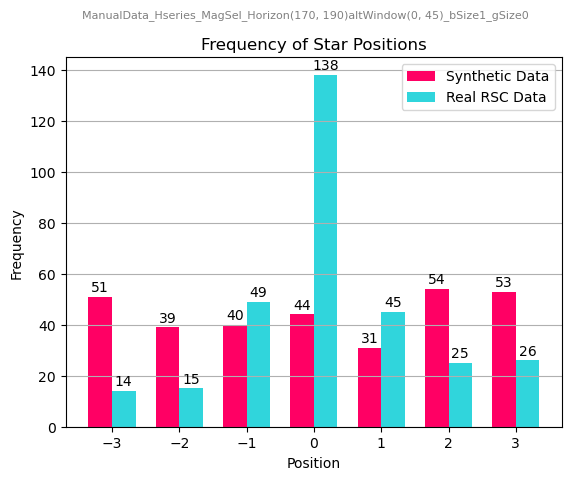

In [12]:
# Section 5: Dashboard Charts
# 5a) Position histogram, to show bias towards the 0 position

# Calculate the count of non-NaN values in each column, subtract the 24 table title rows
counts = df.drop(columns='Unnamed: 0').count()-24
frequency_df = counts.to_frame().T

df2 = {'-3': 14, '-2': 15, '-1': 49, '0': 138, '1': 45, '2': 25, '3': 26} 
frequency_df = frequency_df.append(df2, ignore_index = True)

# Plotting the histogram
bar_width = 0.35  # Width of each bar
positions = frequency_df.columns.astype(int)

plt.bar(positions - bar_width/2, frequency_df.iloc[0], color=(255/255, 0/255, 100/255), width=bar_width, label='Synthetic Data')
plt.bar(positions + bar_width/2, frequency_df.iloc[1], color=(48/255, 213/255, 220/255), width=bar_width, label='Real RSC Data')

# Adding labels on top of bars
for i in range(len(positions)):
    plt.text(positions[i] - bar_width/2, frequency_df.iloc[0, i] + 1, str(frequency_df.iloc[0, i]), ha='center', va='bottom')
    plt.text(positions[i] + bar_width/2, frequency_df.iloc[1, i] + 1, str(frequency_df.iloc[1, i]), ha='center', va='bottom')


# Adding labels and title
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Frequency of Star Positions')
plt.legend()
plt.suptitle(f'{File_Name}', alpha=0.5, fontsize=8)
plt.grid(axis='y')

# Save the figure into desired folder
plt.savefig(f"{path}/freq_by_position.png")

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

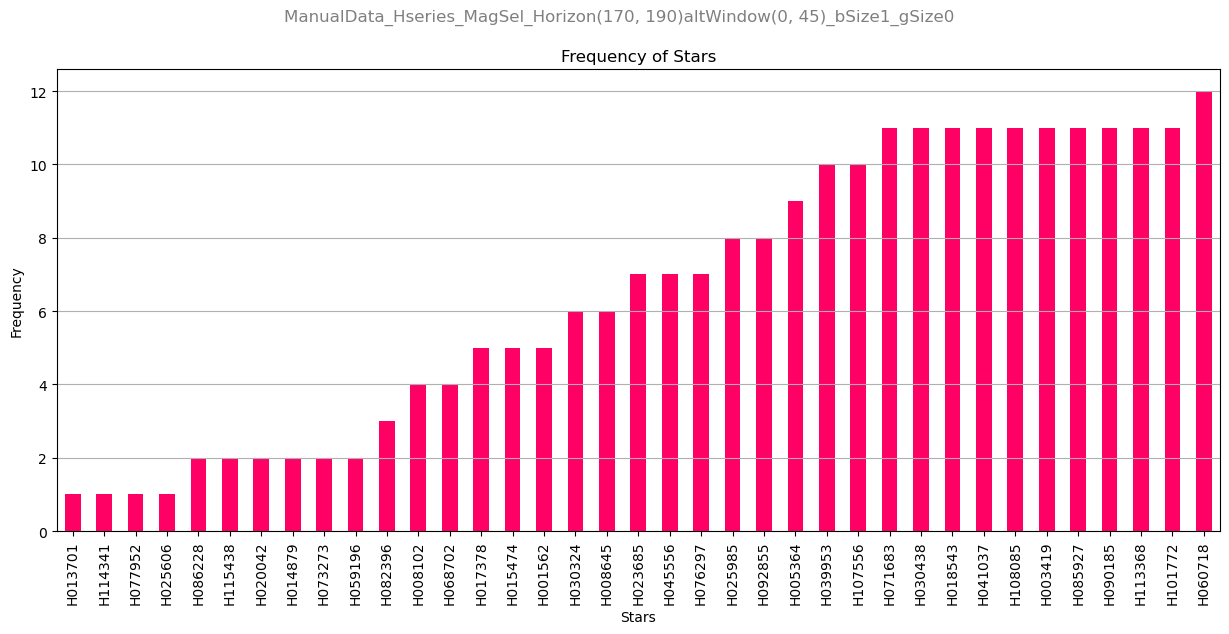

In [13]:
# 5b) Frequency of stars
# Count of how many times each star shows up, order them by frequency
counts1 = ss_df.count(axis=1)
counts_sorted = counts1.sort_values()
counts_sorted_df = counts_sorted.to_frame().T
counts_sorted_df = counts_sorted_df.transpose()
counts_sorted_df = counts_sorted_df.rename(columns={0:'Frequency'})

plt.figure(figsize=(10, 10))

freqBargraph = counts_sorted_df.plot.bar(y='Frequency',color=(255/255, 0/255, 100/255), legend=False)
freqBargraph.set_ylabel('Frequency')
freqBargraph.set_title('Frequency of Stars')

plt.suptitle(f'{File_Name}', alpha=0.5)

freqBargraph.get_figure().set_size_inches(15,6) 

freqBargraph.grid(axis='y')

# Save the figure into desired folder
plt.savefig(f"{path}/freq_by_star.png")

#print(counts_sorted_df)

In [14]:
# 5c) Average position and standard deviation for each star

# Create a mask to filter out NaN values
not_nan_mask = sorted_ss_df.notna()

#sorted_ss_df = ss_df.sort_values(by=ss_df.sum(axis=1), axis=0, ascending=False)

# Calculate average value in each row using only non-NaN values
average_values = sorted_ss_df[not_nan_mask].mean(axis=1)
# Round average values to three decimal places
average_values_rounded = average_values.round(3)

# Calculate standard deviations in each row. Should I round them? 
stdev = sorted_ss_df[not_nan_mask].std(axis=1)
#stdev_rounded = stdev.round(3)

# Print the average values
#print("Average position for each star:")
#for index, value in average_values_rounded.items():
    #print(f"Star {index}: {value}")
    
# Print the standard deviations
#print("Standard deviations for each star:")
#for index, value in stdev.items():
    #print(f"Star {index}: {value}")

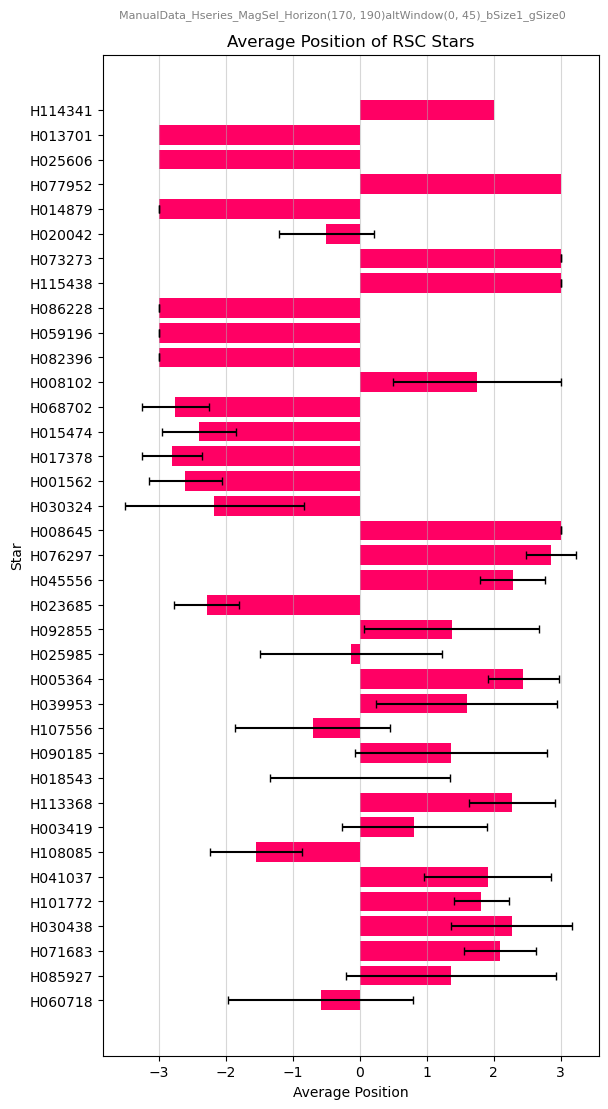

In [15]:
# 5d) Average position and standard deviation chart (most frequent on top)

plt.figure().set_figheight(13)
plt.barh(sorted_ss_df.index, average_values, xerr=stdev, color=(255/255, 0/255, 100/255), capsize=3)

# Adding labels and title
plt.xlabel('Average Position')
plt.ylabel('Star')
plt.title('Average Position of RSC Stars')

# Adding vertical gridlines
plt.grid(axis='x', alpha=0.5)

plt.suptitle(f'{File_Name}', alpha=0.5, x=0.5, y=0.915, fontsize=8)

# Save the figure into desired folder
plt.savefig(f"{path}/avg_position_and_stdev.png")

plt.show()

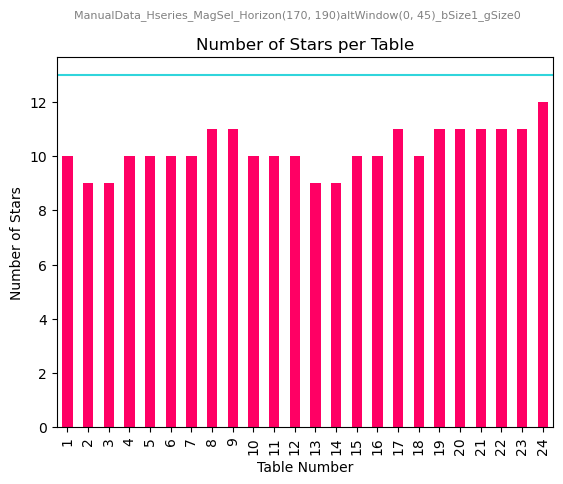

In [26]:
# Section 5e) Number of stars per table

dfStrings = df.copy(deep=True)
dfStrings = df.astype(str)

exclude_values = ['nan', '-3', '-2', '-1', '0', '1', '2', '3']  # Values to exclude (position labels)

# Split df into tables of 15 rows
table_size = 15
num_tables = len(dfStrings) // table_size + 1

# Initialize an empty DataFrame to store results
data = []

for i in range(num_tables):
    start_idx = i * table_size
    end_idx = min((i + 1) * table_size, len(dfStrings))
    table_df = dfStrings.iloc[start_idx:end_idx] # Extract table of dataframe
    table_df = table_df.iloc[:, 1:] # Remove the first column (hour column)
    values_list = table_df.values.flatten().tolist() # Flatten the table into a single list
    values_list = [value for value in values_list if str(value) not in exclude_values] # Exclude position labels
    unique_values_count = len(set(values_list)) # Count unique values (stars)
    data.append(unique_values_count) # Append to the data list

# Create DataFrame from the data list with index as 'Table Number'
dfStarsPerChart = pd.DataFrame(data, columns=['Unique Values Count'], index=range(1, num_tables + 1))

# Print the DataFrame
#print(dfStarsPerChart)

dfStarsPerChart.plot.bar(color=(255/255, 0/255, 100/255),legend=None)

# Adding labels and title
plt.xlabel('Table Number')
plt.ylabel('Number of Stars')
plt.title('Number of Stars per Table')
plt.suptitle(f'{File_Name}', alpha=0.5, fontsize=8)
plt.axhline(y=13, color=(48/255, 213/255, 220/255), linestyle='solid')

# Save the figure into desired folder
plt.savefig(f"{path}/stars_per_table.png")

In [27]:
# Section 6a) Unique values per table dataframe

# Make a copy of original dataframe and convert it to strings
dfStrings = df.copy(deep=True)
dfStrings = df.astype(str)

exclude_values = ['nan', '-3', '-2', '-1', '0', '1', '2', '3','?']  # Values to exclude (position labels)
# Split dataframe into 24 tables
table_size = 15
num_tables = len(dfStrings) // table_size + 1

# Initialize an empty DataFrame to store results
dfStarsByTable = pd.DataFrame()

for i in range(num_tables):
    start_idx = i * table_size
    end_idx = min((i + 1) * table_size, len(dfStrings))
    table_df = dfStrings.iloc[start_idx:end_idx] # Extract table of dataframe
    table_df = table_df.iloc[:, 1:] # Remove the first column (hour column)
    values_list = table_df.values.flatten().tolist() # Flatten the table into a single list
    values_list = [value for value in values_list if str(value) not in exclude_values] # Exclude position labels
    
    # Get unique values and convert to DataFrame
    unique_values = pd.DataFrame([list(set(values_list))], index=[i + 1])
    
    # Transpose the DataFrame and add to dfStarsByTable
    dfStarsByTable = pd.concat([dfStarsByTable, unique_values.T], axis=1)

# Fill empty spaces with NaNs
dfStarsByTable = dfStarsByTable.fillna(np.nan)

# Print the DataFrame
#print(dfStarsByTable)

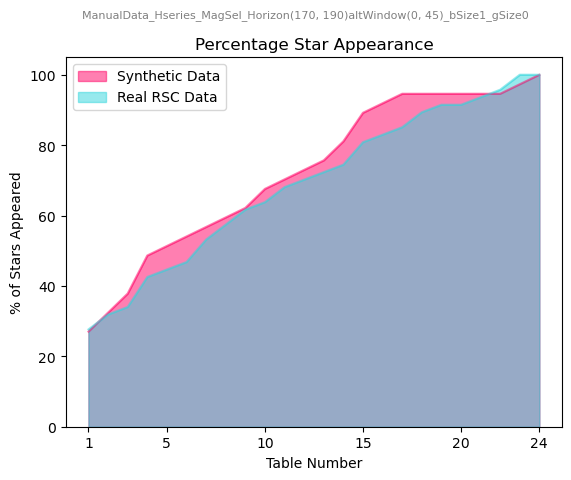

In [18]:
# 6b) Percentage star appearance per table graph

# Create an empty dictionary to store the count of new unique values (stars) for each column (table)
new_unique_counts = {}
unique_values_so_far = set() # Initialize a set to store unique values encountered so far

# Iterate over each column in dfStarsByTable
for col in dfStarsByTable.columns:
    
    # Get the stars in the current column excluding NaNs
    unique_values_in_column = set(dfStarsByTable[col].dropna()) 
    
    # Calculate the count of NEW stars in the current column
    new_unique_count = len(unique_values_in_column - unique_values_so_far) 
    
    # Update the set of stars encountered so far
    unique_values_so_far.update(unique_values_in_column) 
    
    # Store the count of new stars for the current column in the dictionary
    new_unique_counts[col] = (new_unique_count/starCounter)*100 

# Create a DataFrame from the dictionary
new_unique_counts_df = pd.DataFrame.from_dict(new_unique_counts, orient='index', columns=['New Stars'])

# Set the index name
new_unique_counts_df.index.name = 'Table'

# Display the DataFrame
new_unique_counts_df['Synthetic Data'] = new_unique_counts_df['New Stars'].cumsum()
new_unique_counts_df.insert(2, "Real RSC Data", [27.65,31.91,34.04,42.55,44.68,46.80,53.19,57.44,61.70,63.82,68.08,70.21,72.34,74.46,80.85,82.97,85.10,89.36,91.48,91.48,93.61,95.74,100.00,100.00])
#print(new_unique_counts_df)

# Plotting the area plot with 'Stacked Bar' column
ax = new_unique_counts_df.plot.area(stacked=False, y='Synthetic Data', color=(255/255, 0/255, 100/255))

# Adding data from 'Real RSC Data' column to the same plot
new_unique_counts_df.plot.area(stacked=False, y='Real RSC Data', color=(48/255, 213/255, 220/255), ax=ax)

plt.xlabel('Table Number')
plt.ylabel('% of Stars Appeared')
plt.title('Percentage Star Appearance')
plt.suptitle(f'{File_Name}', alpha=0.5, fontsize=8)
plt.xticks([1, 5, 10, 15, 20, 24])

# Save the figure into desired folder
plt.savefig(f"{path}/percent_star_appearance.png")

plt.show()

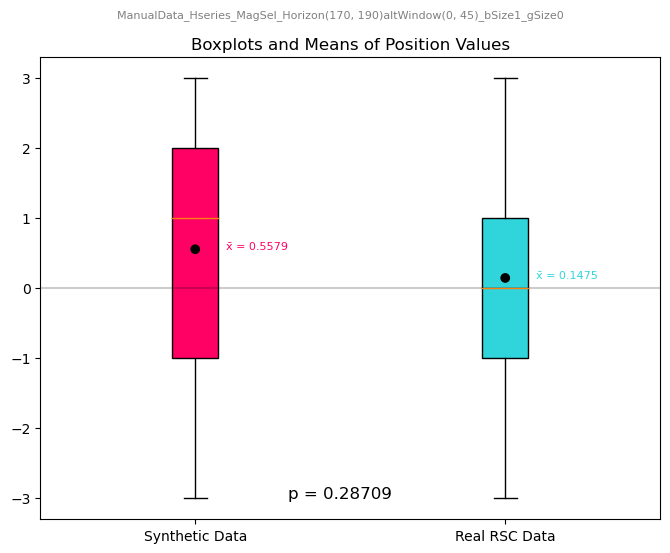

In [19]:
# Section 7: Average value boxplot

# Assuming 'values' is your original data
values = sorted_ss_df.stack().dropna()

# Manually defined data for RSC clocks.
RSCquartiles = [-3,-1,-1,0,1,1,3]

# Combine both datasets into a list
combined_data = [values, RSCquartiles]

# Define RGBA colors for the boxplots
boxplot_colors = [(255/255, 0/255, 100/255, 1), (48/255, 213/255, 220/255, 1)]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Create boxplots for both datasets with custom colors
bp = ax.boxplot(combined_data, patch_artist=True)

# Set colors for boxplots
for patch, color in zip(bp['boxes'], boxplot_colors):
    patch.set_facecolor(color)

# Set labels and legend
ax.set_xticklabels(['Synthetic Data', 'Real RSC Data'])
ax.set_title('Boxplots and Means of Position Values')

#Identify mean values
synthetic_mean_value = np.mean(values)
synthetic_mean_value = synthetic_mean_value.round(4)
RSCmean_value = 0.1475

#TWO SAMPLE T TEST (UNPAIRED) (TWO TAILED)
from scipy.stats import t # The code does not work if I import t where all the other imports are. I don't know why. 

# Find standard deviation for synthetic data
stdevStep1 = sorted(values)
STDEVsynthetic = statistics.stdev(stdevStep1)

#T test equation
t_stat = (0.1475-synthetic_mean_value)/((1.8762/47)+((STDEVsynthetic**2)/starCounter)**(1/2))
dof = starCounter + 45 # Degrees of freedom (dof = number of synthetic stars + 47 RSC stars - 2)

# Find p value
pvalue = t.cdf(-abs(t_stat), dof)
TSpvalue = round(pvalue*2,5) # Multiply 

# Put the p value on the chart
text = ax.text(1.3, -3, f"p = {TSpvalue}", color='black',fontsize=12)

# Plot means as dots (after boxplots)
ax.scatter([1, 2], [synthetic_mean_value, RSCmean_value], color=['black', 'black'], label='Mean', zorder=10, marker="o")

plt.axhline(y=0, xmin=0, xmax=1, alpha = 0.2, color = 'black')

# Show the plot
text = ax.text(1.1, synthetic_mean_value, f"x̄ = {synthetic_mean_value}", color=(255/255, 0/255, 100/255),fontsize=8)
text = ax.text(2.1, RSCmean_value, f"x̄ = {RSCmean_value}", color=(48/255, 213/255, 220/255),fontsize=8)
plt.suptitle(f'{File_Name}', alpha=0.5, y=0.96, fontsize=8)

# Save the figure into desired folder
plt.savefig(f"{path}/boxplot.png")

plt.show()